# Show plots of mutation locations throughout the genomes

In [53]:
%run "Header.ipynb"

In [ ]:
%run "LoadMutationJSONData.ipynb"

In [7]:
import skbio
from parse_sco import parse_sco

## Parameters of the diversity index: $p$ and $m$

See paper for description. These are currently copied from the diversity index notebook; ideally, should be loaded from the same place I guess.

In [51]:
m = 5

percentages = [50, 25, 10, 5, 2, 1, 0.5, 0.25, 0.1, 0.05]

p2pct = {p: p / 100 for p in percentages}
p2mincov = {p: m / p2pct[p] for p in percentages}

# We skip 0.25% (since BACTERIA isn't sufficiently covered for it, although I guess we could show CAMP /
# BACTEROIDALES if desired) and we skip 0.1%, 0.05%, etc. since none of the 3 selected genomes are suff.
# covered for these percentages
percentages_were_gonna_use = percentages[:7]

On percentage p = 50%...
On seq edge_6104...
On seq edge_1671...
On seq edge_2358...
On percentage p = 25%...
On seq edge_6104...
On seq edge_1671...
On seq edge_2358...
On percentage p = 10%...
On seq edge_6104...
On seq edge_1671...
On seq edge_2358...
On percentage p = 5%...
On seq edge_6104...
On seq edge_1671...
On seq edge_2358...
On percentage p = 2%...
On seq edge_6104...
On seq edge_1671...
On seq edge_2358...
On percentage p = 1%...
On seq edge_6104...
On seq edge_1671...
On seq edge_2358...
On percentage p = 0.5%...
On seq edge_6104...
On seq edge_1671...
On seq edge_2358...


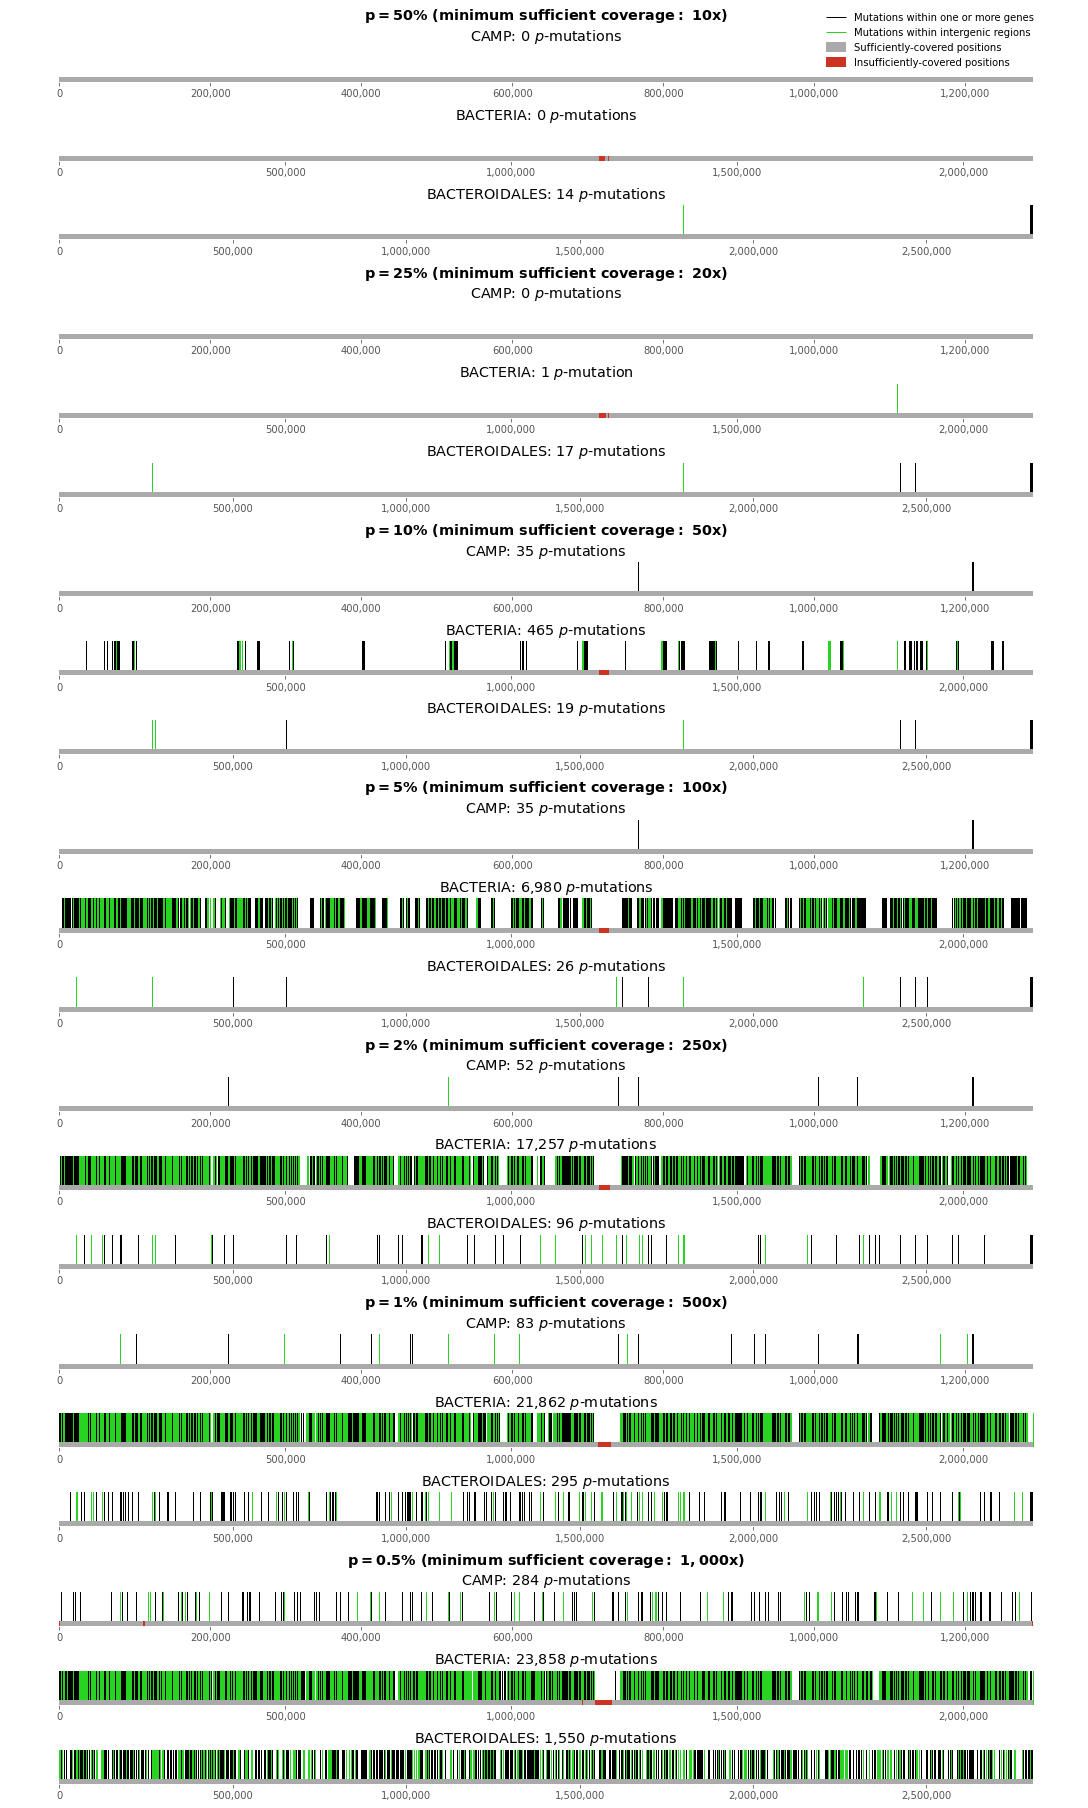

In [62]:
num_rows = 3 * len(percentages_were_gonna_use)
fig, ax = pyplot.subplots(num_rows, 1, gridspec_kw={"hspace": 0.7}, constrained_layout=True)

for pi, p in enumerate(percentages_were_gonna_use):
    print(f"On percentage p = {p}%...")
    for si, seq in enumerate(SEQS):
        print(f"On seq {seq}...")
        
        ax_idx = (pi * 3) + si
        
        genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
        sequence = str(skbio.DNA.read(f"../seqs/{seq}.fasta"))
        positions = range(1, seq2len[seq] + 1)

        num_p_muts = 0
        within_gene_muts = []
        multi_gene_muts = []
        intergenic_muts = []

        pos_to_genes = get_parent_gene_info_of_many_positions(1, seq2len[seq], genes_df)

        sufficiently_covered_positions = []
        insufficiently_covered_positions = []

        for pos in positions:
            cov = seq2pos2totalcov[seq][str(pos)]
            if cov >= p2mincov[p]:

                # Only call mutations based on individual nt mutations, not aggregates. Similar to diversity index
                # computation.
                nonmatches = set("ACGT") - set(sequence[pos - 1])
                alt_freqs = seq2pos2mismatches[seq][str(pos)]
                for alt in alt_freqs:
                    if (alt_freqs[alt] / cov) > p2pct[p]:
                        num_genes = len(pos_to_genes[pos])
                        if num_genes == 0:
                            intergenic_muts.append(pos)
                        else:
                            within_gene_muts.append(pos)
                        num_p_muts += 1
                        break
                sufficiently_covered_positions.append(pos)
            else:
                insufficiently_covered_positions.append(pos)            

        # We use ax_idx == 1 instead of 0 because (as of writing) CAMP has no insufficiently covered
        # positions for the top value of p, so no insufficient position info shows up in the legend.
        # BACTERIA, on the other hand, has cov drops -- which actually helps in this case.
        if ax_idx == 1:
            wgm_label = "Mutations within one or more genes"
            igm_label = "Mutations within intergenic regions"
            sc_label = "Sufficiently-covered positions"
            ic_label = "Insufficiently-covered positions"
        else:
            wgm_label = igm_label = sc_label = ic_label = None

        if ax_idx == num_rows:
            ax[ax_idx].set_xlabel("Sequence position")

        # Draw vertical lines indicating called p-mutations
        # We make it a point to draw these *before* the horizontal lines so that the horizontal lines
        # are drawn on top
        ax[ax_idx].vlines(within_gene_muts, 0, 1, color="#000000", linewidth=1, label=wgm_label)
        ax[ax_idx].vlines(intergenic_muts, 0, 1, color=cp2color[4], linewidth=1, label=igm_label)

        # Draw horizontal lines indicating sufficiently and insufficiently-covered positions
        for type_of_positions, color, label in (
            (sufficiently_covered_positions, "#aaaaaa", sc_label),
            (insufficiently_covered_positions, "#cc3322", ic_label)
        ):
            if len(type_of_positions) > 0:
                runs = convert_to_runs(type_of_positions)
                run_starts = [r[0] for r in runs]
                run_ends = [r[1] for r in runs]
                ax[ax_idx].hlines([0] * len(run_starts), run_starts, run_ends, color=color, linewidth=10, label=label)

        title = f"{seq2name[seq]}: {num_p_muts:,} $p$-mutation"
        if num_p_muts != 1:
            # grammar is hard ok
            title += "s"
        # Add p = (p)% newline before the title whenever we switch to a new value of p
        # the bold text is done using fancy latex stuff: https://stackoverflow.com/a/44123579
        if si == 0:
            title = r"$\bf{p = " + str(p) + "\\%\ (minimum \ sufficient\ coverage:\ " + f"{p2mincov[p]:,.0f}x" ")}$\n" + title
        ax[ax_idx].set_title(title)

        use_thousands_sep(ax[ax_idx].xaxis)

        # Hide the y-axis labels since they don't really matter here: https://stackoverflow.com/a/2176591
        ax[ax_idx].yaxis.set_visible(False)

        ax[ax_idx].set_ylim(0, 1)

        # Make the plot white: https://stackoverflow.com/a/4708018
        ax[ax_idx].patch.set_facecolor("None")
        ax[ax_idx].patch.set_edgecolor("None")
        ax[ax_idx].patch.set_alpha(0)
    
fig.legend(loc=(0.755, 0.96), facecolor="white", edgecolor="white")
fig.set_size_inches(15, 25)
fig.savefig("figs/mutation-locations.png", bbox_inches="tight")